In [22]:
import xarray as xr # for data handling
import numpy as np # for maths
import matplotlib as mpl # plotlibrary
import matplotlib.pyplot as plt # for the plots 
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm # for making a log 10 colorscale
import cartopy # library for making maps
from cartopy import crs as ccrs # Projection Library
from cartopy.crs import Stereographic, PlateCarree, Mollweide # Map projections I use00
from cartopy.feature import LAND, COASTLINE # Vectordata of the Coastline and land for making the maps prettier
import cmocean
from glob import glob
import dask
from scipy.io import loadmat
import gsw

# Exercise 1

In [23]:
def deg360to180(ds, lon_dim):
    dim_name = ds[lon_dim].dims[0]
    ds["lon_new"] = xr.where(
    ds[lon_dim]>180, # take all the values, where X is less than zero
    ds[lon_dim]-360, # if true, add 360
    ds[lon_dim], # if false take them verbatim
    )
    ds = (
        ds
        .swap_dims(dict(zip([dim_name], ["lon_new"]))) # Make the new values to our dimension
        .sortby("lon_new") # make sure to sort them
        .drop_vars(lon_dim) # drop the old Dimension
        .rename(dict(zip(["lon_new"],[dim_name])))
    )#
    return ds

## Read Files

In [24]:
from glob import glob
print(glob("./MIMOC_ML_v2.2_PT_S/*"))


['./MIMOC_ML_v2.2_PT_S/MIMOC_ML_v2.2_PT_S_MLP_month05.nc', './MIMOC_ML_v2.2_PT_S/MIMOC_ML_v2.2_PT_S_MLP_month10.nc', './MIMOC_ML_v2.2_PT_S/MIMOC_ML_v2.2_PT_S_MLP_month09.nc', './MIMOC_ML_v2.2_PT_S/MIMOC_ML_v2.2_PT_S_MLP_month12.nc', './MIMOC_ML_v2.2_PT_S/MIMOC_ML_v2.2_PT_S_MLP_month06.nc', './MIMOC_ML_v2.2_PT_S/MIMOC_ML_v2.2_PT_S_MLP_month04.nc', './MIMOC_ML_v2.2_PT_S/MIMOC_ML_v2.2_PT_S_MLP_month01.nc', './MIMOC_ML_v2.2_PT_S/MIMOC_ML_v2.2_PT_S_MLP_month07.nc', './MIMOC_ML_v2.2_PT_S/MIMOC_ML_v2.2_PT_S_MLP_month02.nc', './MIMOC_ML_v2.2_PT_S/MIMOC_ML_v2.2_PT_S_MLP_month08.nc', './MIMOC_ML_v2.2_PT_S/MIMOC_ML_v2.2_PT_S_MLP_month03.nc', './MIMOC_ML_v2.2_PT_S/MIMOC_ML_v2.2_PT_S_MLP_month11.nc']


In [27]:
mimoc_files = glob("./MIMOC_ML_v2.2_PT_S/*")
mimoc = xr.open_mfdataset(mimoc_files, combine="nested", concat_dim="month", compat="no_conflicts", data_vars="different")

# mimoc = xr.open_mfdataset(
#     mimoc_files,
#     combine="nested",
#     concat_dim="month",
#     compat="no_conflicts",
#     data_vars="different"
# )
mimoc = mimoc.assign_coords(
    dict(
        lat=mimoc.LATITUDE,
        lon=mimoc.LONGITUDE,
    )
).swap_dims(
    dict(
        LAT="lat",
        LONG="lon",
    )
).drop_vars(("LATITUDE", "LONGITUDE")).sortby(["lon", "lat"])
mimoc = deg360to180(mimoc, "lon")
mimoc.SALINITY_MIXED_LAYER.isel(month=0).plot()

ImportError: chunk manager 'dask' is not available. Please make sure 'dask' is installed and importable.

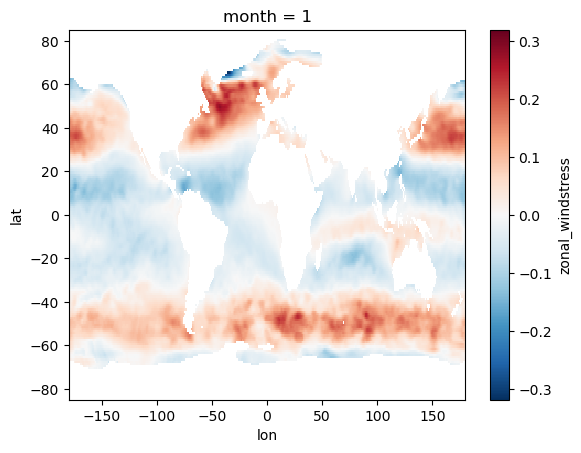

In [ ]:
lats = loadmat("./atae.mat").get("lat").T[0]
lons = loadmat("./atae.mat").get("lon").T[0]
months = np.arange(1,13)
windstress = xr.Dataset(
    data_vars=dict(
        zonal_windstress=(["LAT","LONG","month"], loadmat("./atae.mat").get("atae")),
        meridional_windstress=(["LAT","LONG","month"], loadmat("./atae.mat").get("atae")),
        ),
    coords=dict(
        lat=("LAT", lats),
        lon=("LONG", lons),
        month=("month", months),
    ),
).swap_dims(dict(LAT="lat", LONG="lon")).sortby("lon")
windstress = deg360to180(windstress, "lon")
windstress.zonal_windstress.isel(month=0).plot()

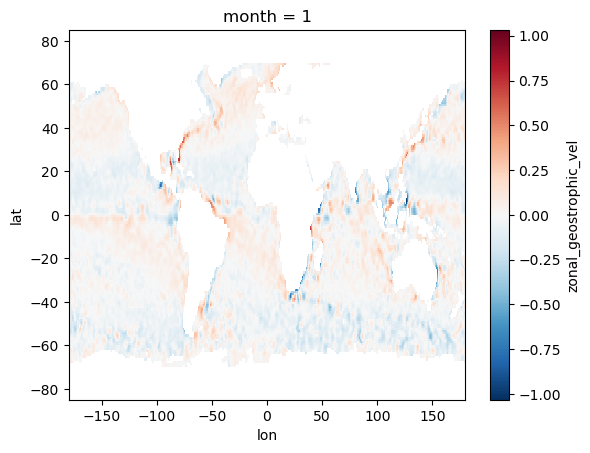

In [ ]:
lats = loadmat("./Drifter_climatology.mat").get("lat").T[0]
lons = loadmat("./Drifter_climatology.mat").get("lon").T[0]
months = np.arange(1,13)
geostrophic_velocity = xr.Dataset(
    data_vars=dict(
        zonal_geostrophic_vel=(["LAT","LONG","month"], loadmat("./Drifter_climatology.mat").get("iV_g")),
        meridional_geostrophic_vel=(["LAT","LONG","month"], loadmat("./Drifter_climatology.mat").get("iU_g")),
        ),
    coords=dict(
        lat=("LAT", lats),
        lon=("LONG", lons),
        month=("month", months),
    ),
).swap_dims(dict(LAT="lat", LONG="lon")).sortby("lon")
geostrophic_velocity = deg360to180(geostrophic_velocity, "lon")
geostrophic_velocity.zonal_geostrophic_vel.isel(month=0).plot()

## Ekman Pumping

In [ ]:
earth_rotation_rate = 2*np.pi/(24*60*60)
earth_rotation_rate

7.27220521664304e-05

In [ ]:
windstress["coriolis_parameter"] = 2*earth_rotation_rate*np.deg2rad(windstress.lat).assign_attrs(dict(long_name="Coriolis Parameter"))

In [ ]:
windstress["meridional_ekman_transport"] = windstress.zonal_windstress / windstress.coriolis_parameter
windstress["zonal_ekman_transport"] = - windstress.meridional_windstress / windstress.coriolis_parameter

In [ ]:
1/mimoc.density * (windstress.interp(coords=dict(lat=mimoc.lat, lon=mimoc.lon)).meridional_ekman_transport + windstress.interp(coords=dict(lat=mimoc.lat, lon=mimoc.lon)).zonal_ekman_transport )

AttributeError: 'Dataset' object has no attribute 'density'

In [ ]:
mimoc["conservative_temperature"] = gsw.conversions.CT_from_pt(mimoc.SALINITY_MIXED_LAYER, mimoc.POTENTIAL_TEMPERATURE_MIXED_LAYER).assign_attrs(dict(long_name="Conservative Temperatue"))
mimoc["density"] = gsw.density.rho(mimoc.SALINITY_MIXED_LAYER, mimoc.conservative_temperature, 0).assign_attrs(dict(long_name="Density"))

In [ ]:
mimoc_south_atlantic = mimoc.sel(month=8, lon=slice(-60,30), lat=slice(-70, 0))
mimoc_south_atlantic

<xarray.Dataset> Size: 716kB
Dimensions:                            (lat: 141, lon: 181)
Coordinates:
  * lat                                (lat) float32 564B -70.0 -69.5 ... 0.0
  * lon                                (lon) float32 724B -60.0 -59.5 ... 30.0
Data variables:
    SALINITY_MIXED_LAYER               (lat, lon) float32 102kB dask.array<chunksize=(141, 181), meta=np.ndarray>
    POTENTIAL_TEMPERATURE_MIXED_LAYER  (lat, lon) float32 102kB dask.array<chunksize=(141, 181), meta=np.ndarray>
    DEPTH_MIXED_LAYER                  (lat, lon) float32 102kB dask.array<chunksize=(141, 181), meta=np.ndarray>
    conservative_temperature           (lat, lon) float64 204kB dask.array<chunksize=(141, 181), meta=np.ndarray>
    density                            (lat, lon) float64 204kB dask.array<chunksize=(141, 181), meta=np.ndarray>

In [ ]:
windstress.sel(month=8, LAT=slice(-70,10), lon=slice(-60,30)).zonal_windstress.plot()

KeyError: "'LAT' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'lat': 170, 'lon': 360, 'month': 12})"

## Exercise 2

Using latitude 10.50° for '10°N'
Using latitude -9.50° for '10°S'
Mean Ekman transport at 10N: -0.227 Sv/deg
Mean Ekman transport at 10S: 0.208 Sv/deg


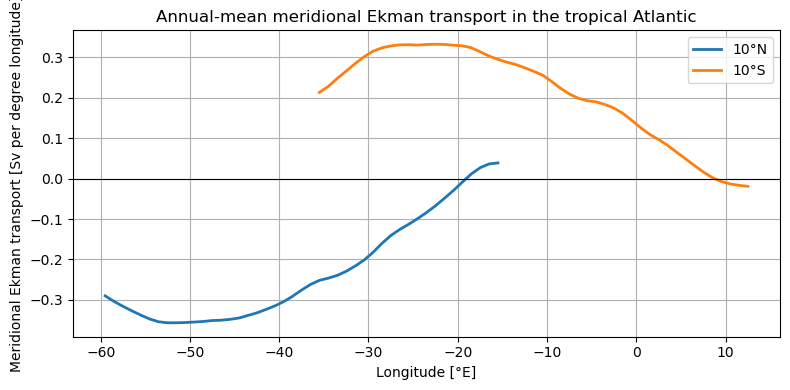

In [ ]:
# Exercise 2: Ekman transport in the tropical Atlantic

rho0 = 1025.0          # reference density [kg m^-3]
R_earth = 6.371e6      # Earth radius [m]

# Coriolis parameter f = 2 * Omega * sin(phi)
coriolis = 2 * earth_rotation_rate * np.sin(np.deg2rad(windstress["lat"]))
windstress["coriolis_parameter"] = coriolis.assign_attrs(
    dict(long_name="Coriolis parameter", units="s^-1")
)

# Annual mean wind stress
windstress_annual = windstress.mean(dim="month", skipna=True)

# Meridional Ekman transport per unit width M_Ey = tau_x /(rho0 * f)
windstress_annual["meridional_ekman_transport"] = (
    windstress_annual.zonal_windstress
    / (rho0 * windstress_annual.coriolis_parameter)
)
windstress_annual.meridional_ekman_transport.attrs.update(
    dict(long_name="Meridional Ekman transport per unit width",
         units="m^2 s^-1")
)

# Restrict to Atlantic sector
atlantic = windstress_annual.sel(lon=slice(-60, 30))

# Grid rows closest to 10°N and 10°S
ekman_10N = atlantic.meridional_ekman_transport.sel(lat=10, method="nearest")
ekman_10S = atlantic.meridional_ekman_transport.sel(lat=-10, method="nearest")

lat_10N = float(ekman_10N.lat)
lat_10S = float(ekman_10S.lat)

print(f"Using latitude {lat_10N:.2f}° for '10°N'")
print(f"Using latitude {lat_10S:.2f}° for '10°S'")

# Convert to transport in Sv per degree longitude
dlambda_rad = np.deg2rad(1.0)

dx_10N = R_earth * np.cos(np.deg2rad(lat_10N)) * dlambda_rad   # [m per 1° lon]
dx_10S = R_earth * np.cos(np.deg2rad(lat_10S)) * dlambda_rad   # [m per 1° lon]

T_10N_Sv = ekman_10N * dx_10N / 1e6        # [Sv per degree longitude]
T_10S_Sv = ekman_10S * dx_10S / 1e6        # [Sv per degree longitude]

print(f"Mean Ekman transport at 10N: {float(T_10N_Sv.mean()):.3f} Sv/deg")
print(f"Mean Ekman transport at 10S: {float(T_10S_Sv.mean()):.3f} Sv/deg")

# Plot meridional Ekman transport vs longitude
plt.figure(figsize=(8, 4))
plt.plot(T_10N_Sv["lon"], T_10N_Sv, label="10°N", linewidth=2)
plt.plot(T_10S_Sv["lon"], T_10S_Sv, label="10°S", linewidth=2)
plt.axhline(0, color="k", linewidth=0.8)
plt.xlabel("Longitude [°E]")
plt.ylabel("Meridional Ekman transport [Sv per degree longitude]")
plt.title("Annual-mean meridional Ekman transport in the tropical Atlantic")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
